In [1]:
import os
from typing import List, Tuple, Dict, Union, Optional

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import random
random.seed(2023)

import numpy as np

np.random.seed(2023)  # Set seed for reproducibility
import keras
import tensorflow as tf
from tqdm import tqdm

tf.random.set_seed(2023)
tf.config.run_functions_eagerly(True)
keras.backend.clear_session()
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.utils import plot_model
from keras.models import load_model
from keras.optimizers import Adam


from archs.segmentation.unet import build_unet
from data.augmentor import Augmentor
from data.data_generator import DataLoader, DataGeneratorAugmented
from uncertainty.monte_carlo_dropout import ModelWithMonteCarlo
from utils.callbacks import PlotMetricsCallback, PlotSampleCallback
from utils.helper import create_dirs, write_setup
from utils.loss import FocalDiceLoss, dice_coef
from utils.visualizations import plot_sample
from data.data_generator import loaders

gen_dir = "/home/thjo/Datasets/Brats/"
fp16 = False
gpus = tf.config.experimental.list_physical_devices('GPU')
if len(gpus) > 0:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    print(f"GPU(s) available (using '{gpus[0].name}'). Training will be lightning fast!")
    if fp16:
        details = tf.config.experimental.get_device_details(gpus[0])
        compute_capability = details.get('compute_capability')
        print("Compute capability:", compute_capability)
        if compute_capability[0] > 6:
            print("Turning on mixed_float16")
            policy = tf.keras.mixed_precision.Policy('mixed_float16')
            tf.keras.mixed_precision.set_global_policy(policy)
else:
    print("No GPU(s) available. Training will be suuuuper slow!")

from uncertainty.monte_carlo_dropout import MonteCarloDropoutModel
from utils.visualizations import plot_predictions
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from utils.helper import prediction_threshold



GPU(s) available (using '/physical_device:GPU:0'). Training will be lightning fast!


In [2]:
learning_rate = 1e-2
weight_decay = 0
loss = FocalDiceLoss(w_focal=0.8, w_dice=0.2, gamma=3.0)
optimizer = Adam(learning_rate=learning_rate,decay=weight_decay)

In [3]:
unet = load_model("models/unet_final1/checkpoints", custom_objects={'FocalDiceLoss': FocalDiceLoss, 'dice_coef': dice_coef},compile=False)
unet.compile(loss=loss, metrics=dice_coef, optimizer=optimizer)
monte_carlo_model = MonteCarloDropoutModel(unet)
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 4)]  0           []                               
                                                                                                  
 Encoder (Functional)           [(None, 32, 32, 16)  1227456     ['input_2[0][0]']                
                                , (None, 16, 16, 32                                               
                                ),                                                                
                                 (None, 8, 8, 64),                                                
                                 (None, 4, 4, 128),                                               
                                 (None, 2, 2, 256)]                                           

In [4]:
gen_train, gen_val, gen_test, augmentor = loaders(gen_dir, 64, True)

/home/thjo/miniconda3/envs/tf2/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


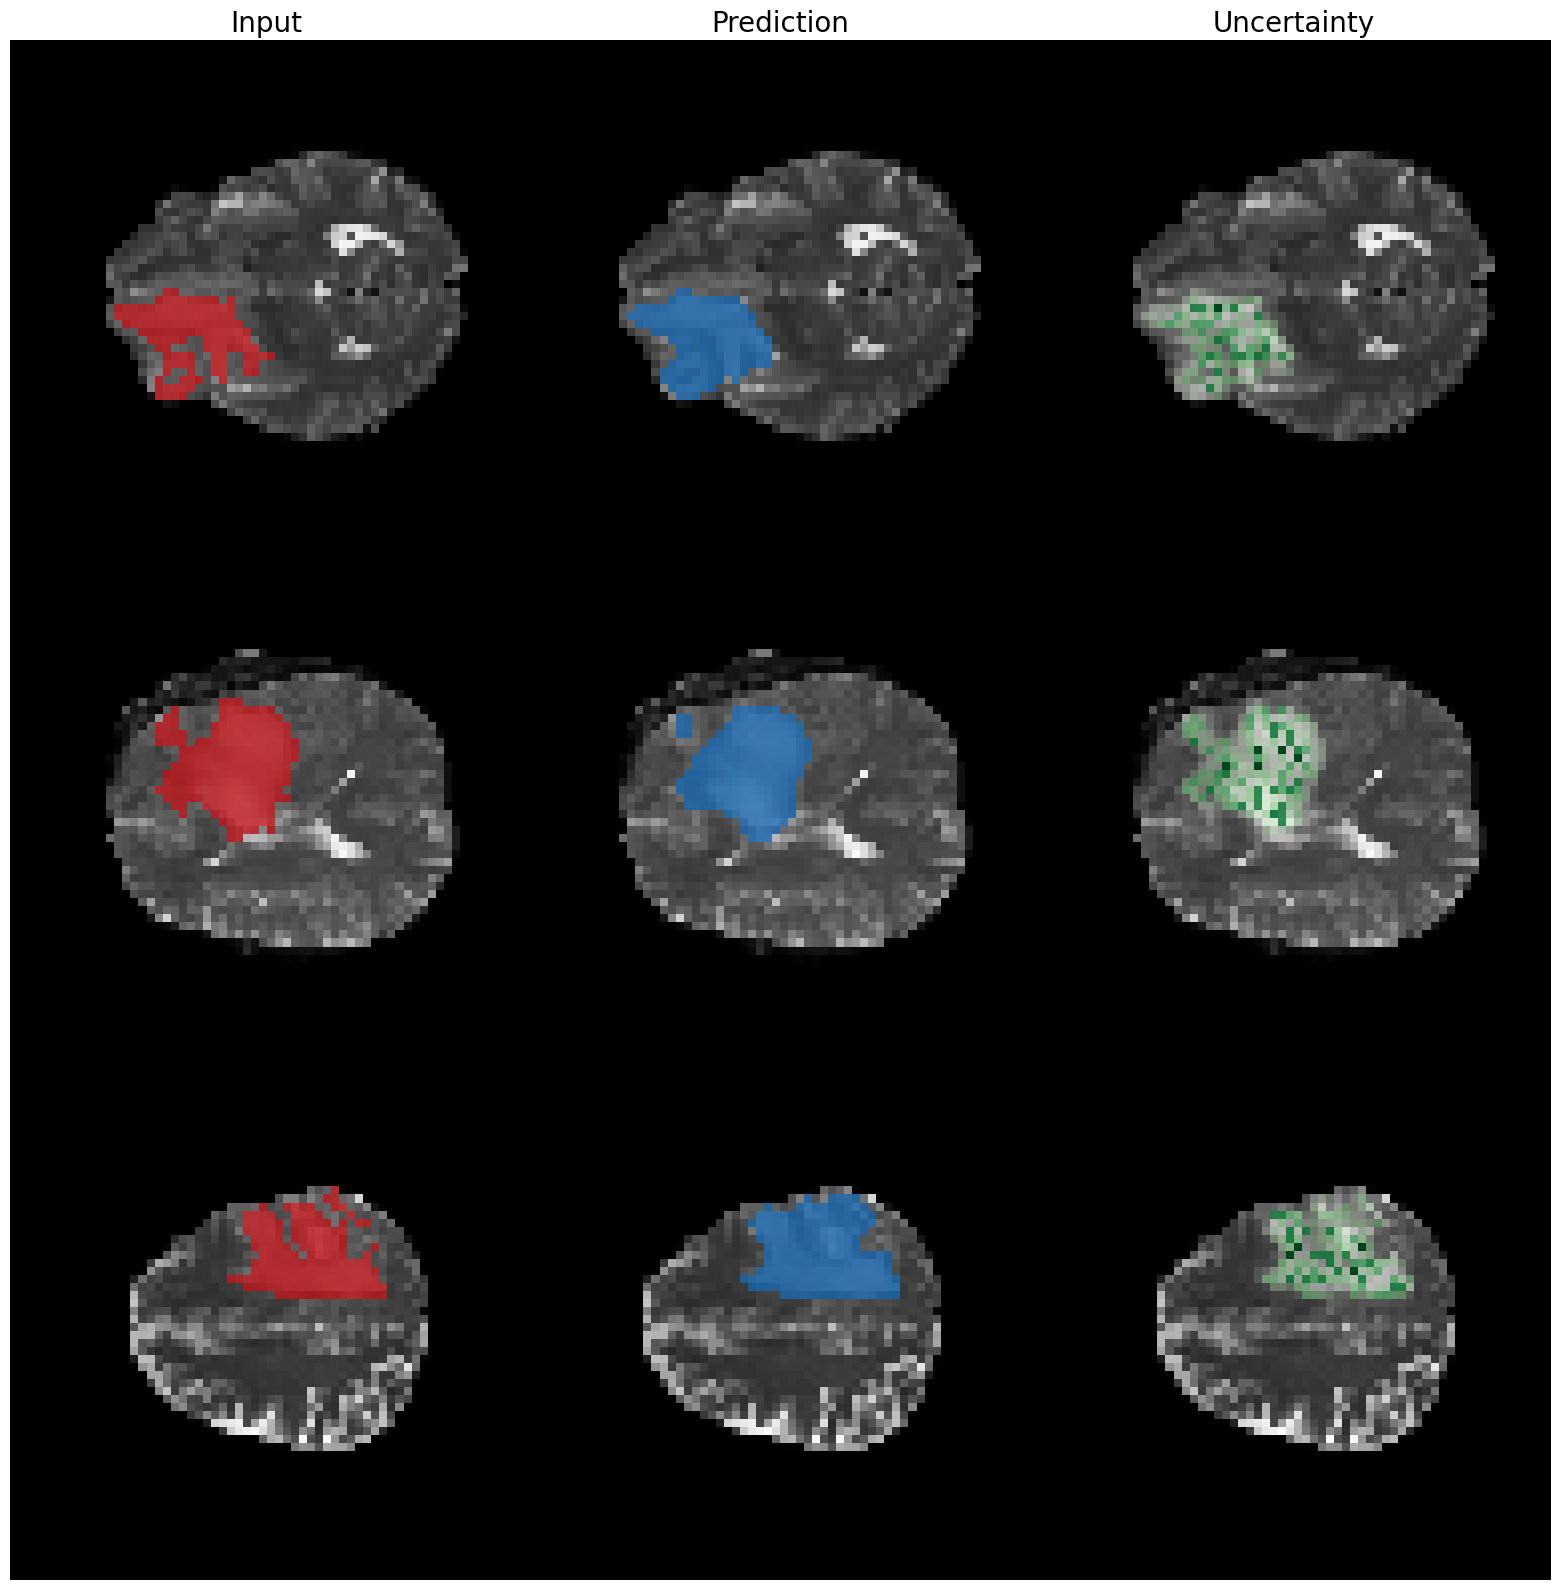

In [5]:
plot_predictions(gen_val, n=3, model=unet, unc_model=monte_carlo_model, title="Validation Samples")

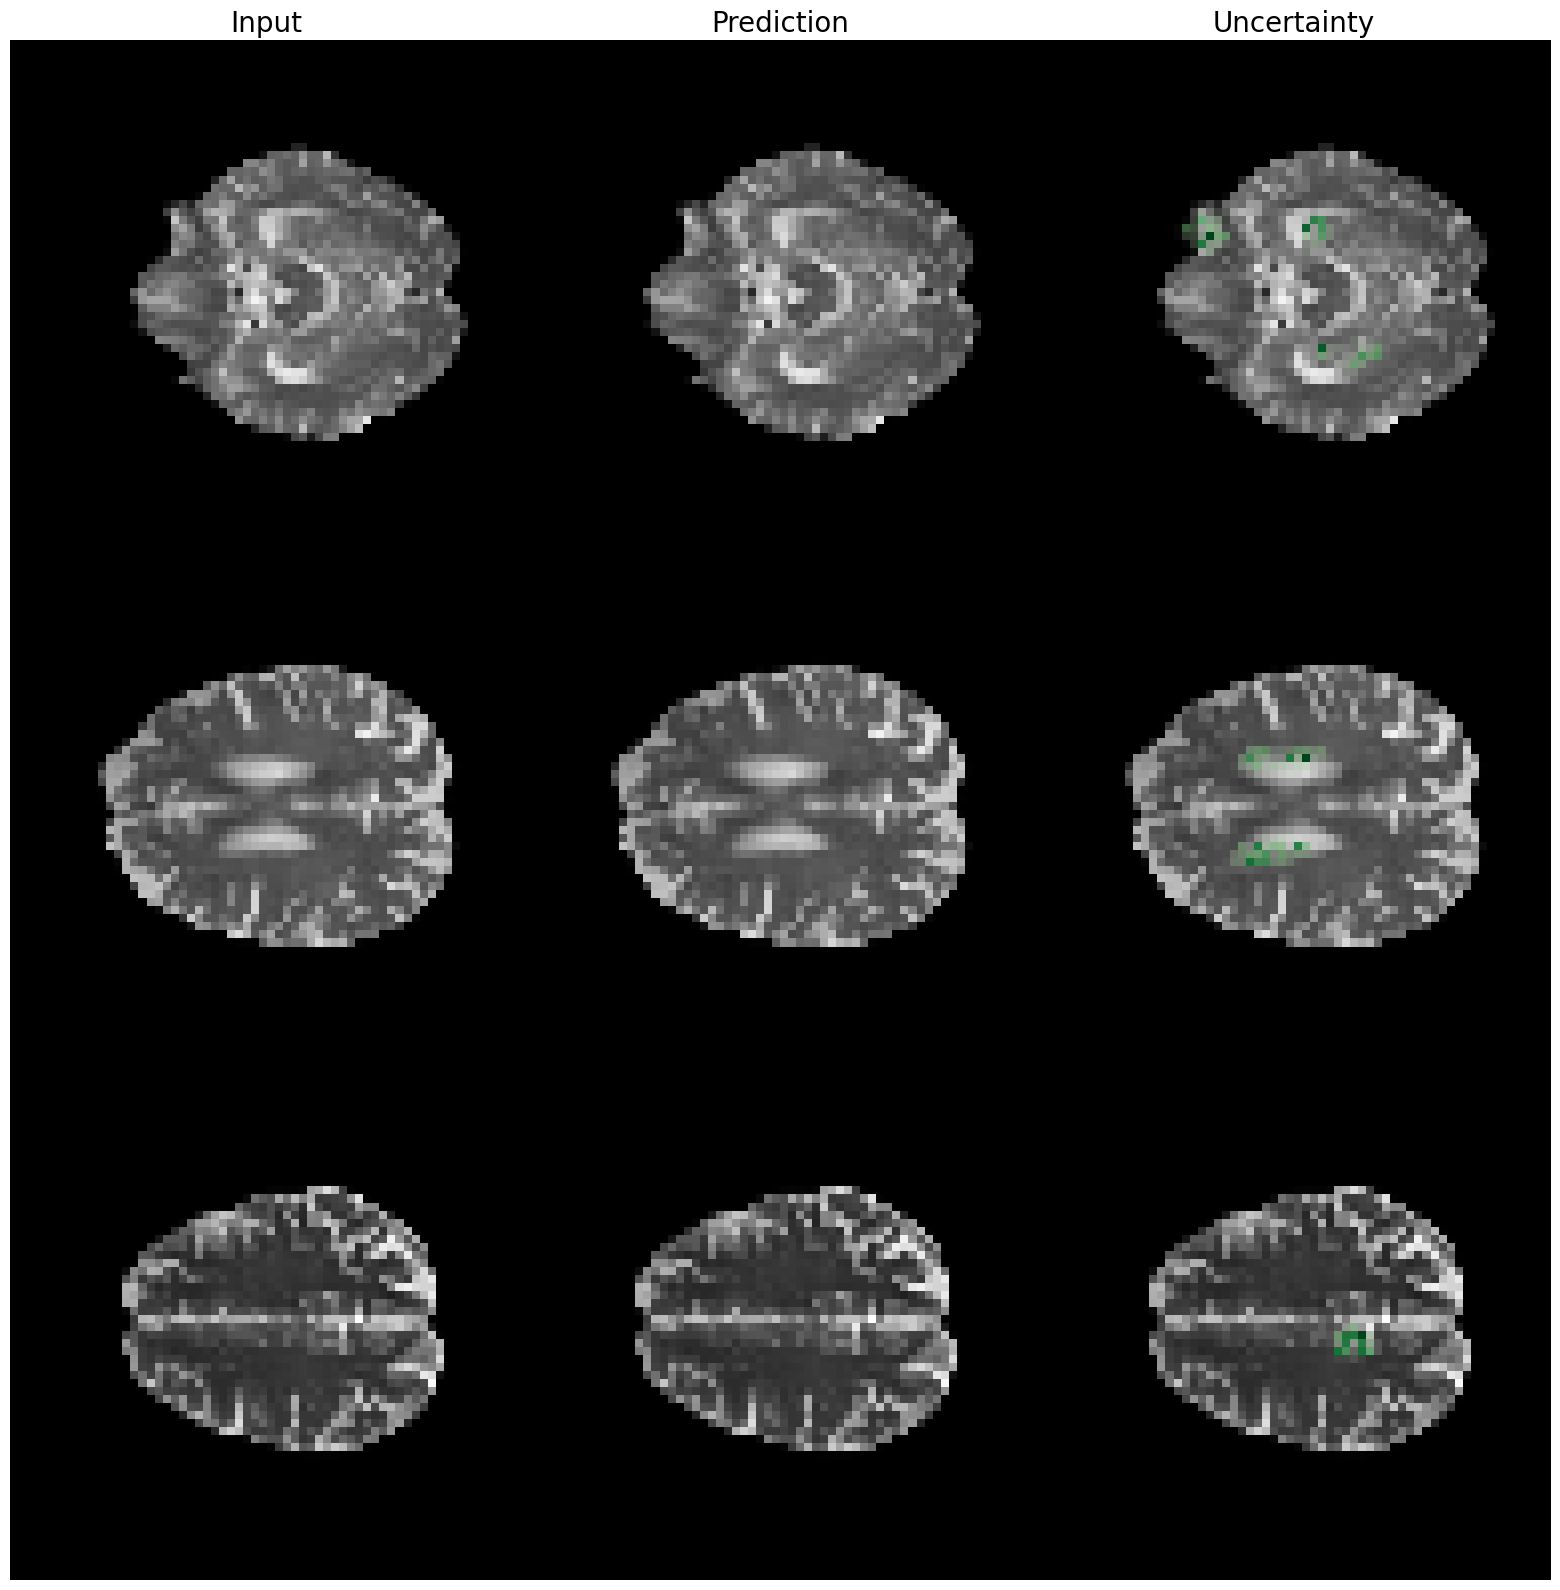

In [6]:
plot_predictions(gen_test, n=3, model=unet, unc_model=monte_carlo_model, title="Testing Samples")

In [16]:
test_res = unet.evaluate(gen_test, return_dict=True)
print(f"Test dice: {test_res['dice_coef']:.4f}")

 3/15 [=====>........................] - ETA: 0s - loss: 0.1016 - dice_coef: 0.7048

/home/thjo/miniconda3/envs/tf2/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


15/15 [==============================] - 1s 40ms/step - loss: 0.1216 - dice_coef: 0.6734
Test dice: 0.6734


## Data analysis

In [8]:
def extract_data(data):
    """Stack all the data in a single array"""
    all_inputs = []
    all_masks = []
    for idx, (inputs, mask) in tqdm(enumerate(data), desc=f"Extracting {data.data_path}"): # Add the additional inputs inside the brackets
        all_inputs.append(inputs)
        all_masks.append(mask)
    all_inputs = np.concatenate(all_inputs, axis=0)
    all_masks = np.concatenate(all_masks, axis=0)
    return all_inputs, all_masks
all_train, all_train_masks = extract_data(gen_train)
all_val, all_val_masks = extract_data(gen_val)
all_test, all_test_masks = extract_data(gen_test)

Extracting /home/thjo/Datasets/Brats/training: 125it [01:22,  1.51it/s]
Extracting /home/thjo/Datasets/Brats/validating: 15it [00:09,  1.63it/s]
Extracting /home/thjo/Datasets/Brats/testing: 15it [00:00, 31.97it/s]


In [9]:
def analysis_dataset(all_data:np.ndarray, all_masks:np.ndarray, title:str):
    mean_data_img = np.mean(all_train, axis=(0))
    n_channels = mean_data_img.shape[-1]
    mean_masks_img = np.mean(all_masks, axis=(0))
    mean_data = np.mean(all_train, axis=(0, 1, 2))
    mean_mask = float(np.mean(all_masks, axis=(0, 1, 2)))
    std_data_img = np.std(all_train, axis=(0))
    std_masks_img = np.std(all_masks, axis=(0))
    std_data = np.std(all_train, axis=(0, 1, 2))
    std_mask = float(np.std(all_masks, axis=(0, 1, 2)))

    print(f"Mean {title} inputs:")
    for channel in range(n_channels):
        print(f"Channel {channel}: {mean_data[channel]:.2e} +- {std_data[channel]:.2e}")
    print(f"Mean of {title} mask: {mean_mask:.2e} +- {std_mask:.2e}")
    return mean_data_img, mean_masks_img, std_data_img, std_masks_img

In [10]:
mean_train_data_img, mean_train_masks_img, std_train_data_img, std_train_masks_img = analysis_dataset(all_train, all_train_masks, "training")
mean_val_data_img, mean_val_masks_img, std_val_data_img, std_val_masks_img = analysis_dataset(all_val, all_val_masks, "validation")
mean_test_data_img, mean_test_masks_img, std_test_data_img, std_test_masks_img = analysis_dataset(all_test, all_test_masks, "testing")


Mean training inputs:
Channel 0: 1.44e-01 +- 2.73e-01
Channel 1: 8.91e-02 +- 1.75e-01
Channel 2: 9.01e-02 +- 1.77e-01
Channel 3: 1.07e-01 +- 2.12e-01
Mean of training mask: 1.68e-02 +- 1.28e-01
Mean validation inputs:
Channel 0: 1.44e-01 +- 2.73e-01
Channel 1: 8.91e-02 +- 1.75e-01
Channel 2: 9.01e-02 +- 1.77e-01
Channel 3: 1.07e-01 +- 2.12e-01
Mean of validation mask: 2.07e-02 +- 1.42e-01
Mean testing inputs:
Channel 0: 1.44e-01 +- 2.73e-01
Channel 1: 8.91e-02 +- 1.75e-01
Channel 2: 9.01e-02 +- 1.77e-01
Channel 3: 1.07e-01 +- 2.12e-01
Mean of testing mask: 1.48e-02 +- 1.21e-01


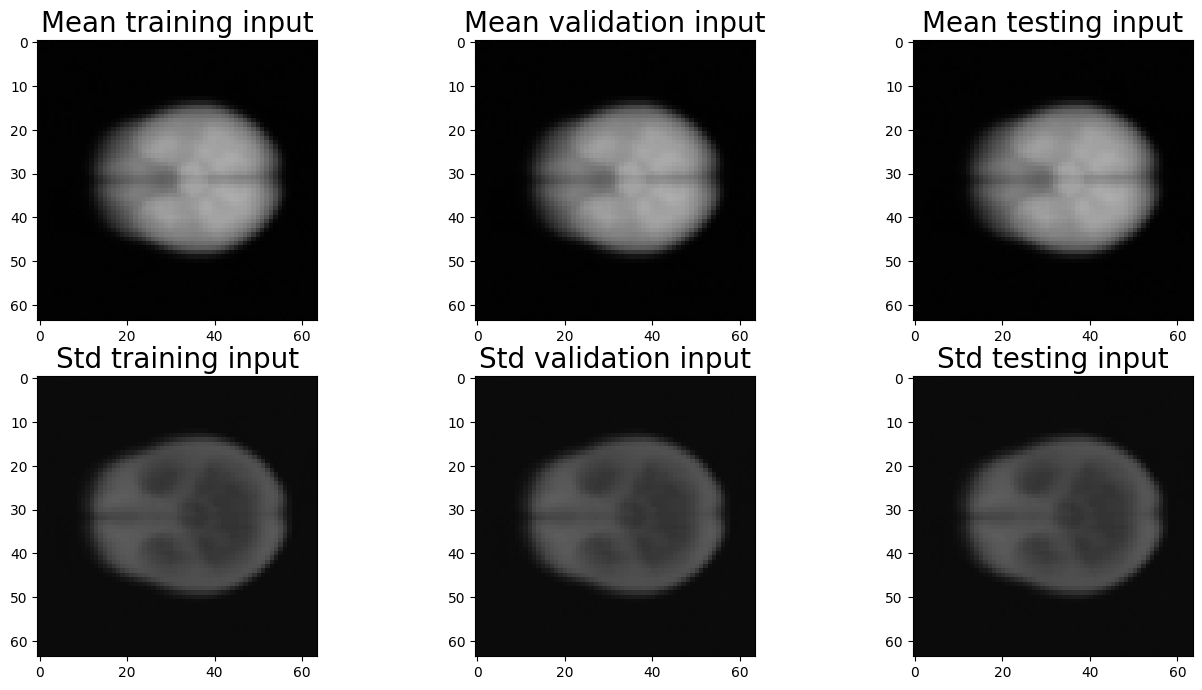

In [11]:
fig,axs = plt.subplots(2,3,figsize=(16,8),dpi=100)
axs[0,0].imshow(mean_train_data_img[...,0],cmap='gray',vmin=0,vmax=1)
axs[0,0].set_title('Mean training input',fontsize=20)
axs[0,1].imshow(mean_val_data_img[...,0],cmap='gray',vmin=0,vmax=1)
axs[0,1].set_title('Mean validation input',fontsize=20)
axs[0,2].imshow(mean_test_data_img[...,0],cmap='gray',vmin=0,vmax=1)
axs[0,2].set_title('Mean testing input',fontsize=20)
axs[1,0].imshow(std_train_data_img[...,0],cmap='gray',vmin=0,vmax=1)
axs[1,0].set_title('Std training input',fontsize=20)
axs[1,1].imshow(std_val_data_img[...,0],cmap='gray',vmin=0,vmax=1)
axs[1,1].set_title('Std validation input',fontsize=20)
axs[1,2].imshow(std_test_data_img[...,0],cmap='gray',vmin=0,vmax=1)
axs[1,2].set_title('Std testing input',fontsize=20)
plt.show()

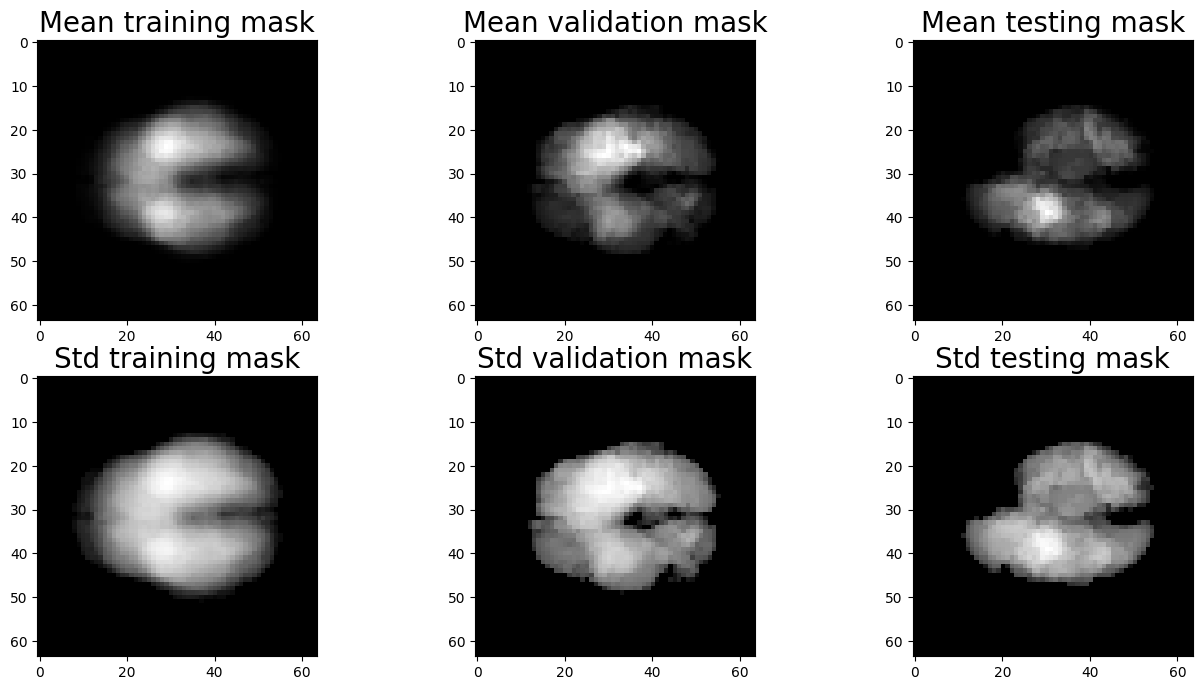

In [12]:
def normalize(img):
    return (img - np.min(img)) / (np.max(img) - np.min(img))
fig,axs = plt.subplots(2,3,figsize=(16,8),dpi=100)
axs[0,0].imshow(normalize(mean_train_masks_img[...,0]),cmap='gray',vmin=0,vmax=1)
axs[0,0].set_title('Mean training mask',fontsize=20)
axs[0,1].imshow(normalize(mean_val_masks_img[...,0]),cmap='gray',vmin=0,vmax=1)
axs[0,1].set_title('Mean validation mask',fontsize=20)
axs[0,2].imshow(normalize(mean_test_masks_img[...,0]),cmap='gray',vmin=0,vmax=1)
axs[0,2].set_title('Mean testing mask',fontsize=20)
axs[1,0].imshow(normalize(std_train_masks_img[...,0]),cmap='gray',vmin=0,vmax=1)
axs[1,0].set_title('Std training mask',fontsize=20)
axs[1,1].imshow(normalize(std_val_masks_img[...,0]),cmap='gray',vmin=0,vmax=1)
axs[1,1].set_title('Std validation mask',fontsize=20)
axs[1,2].imshow(normalize(std_test_masks_img[...,0]),cmap='gray',vmin=0,vmax=1)
axs[1,2].set_title('Std testing mask',fontsize=20)
plt.show()


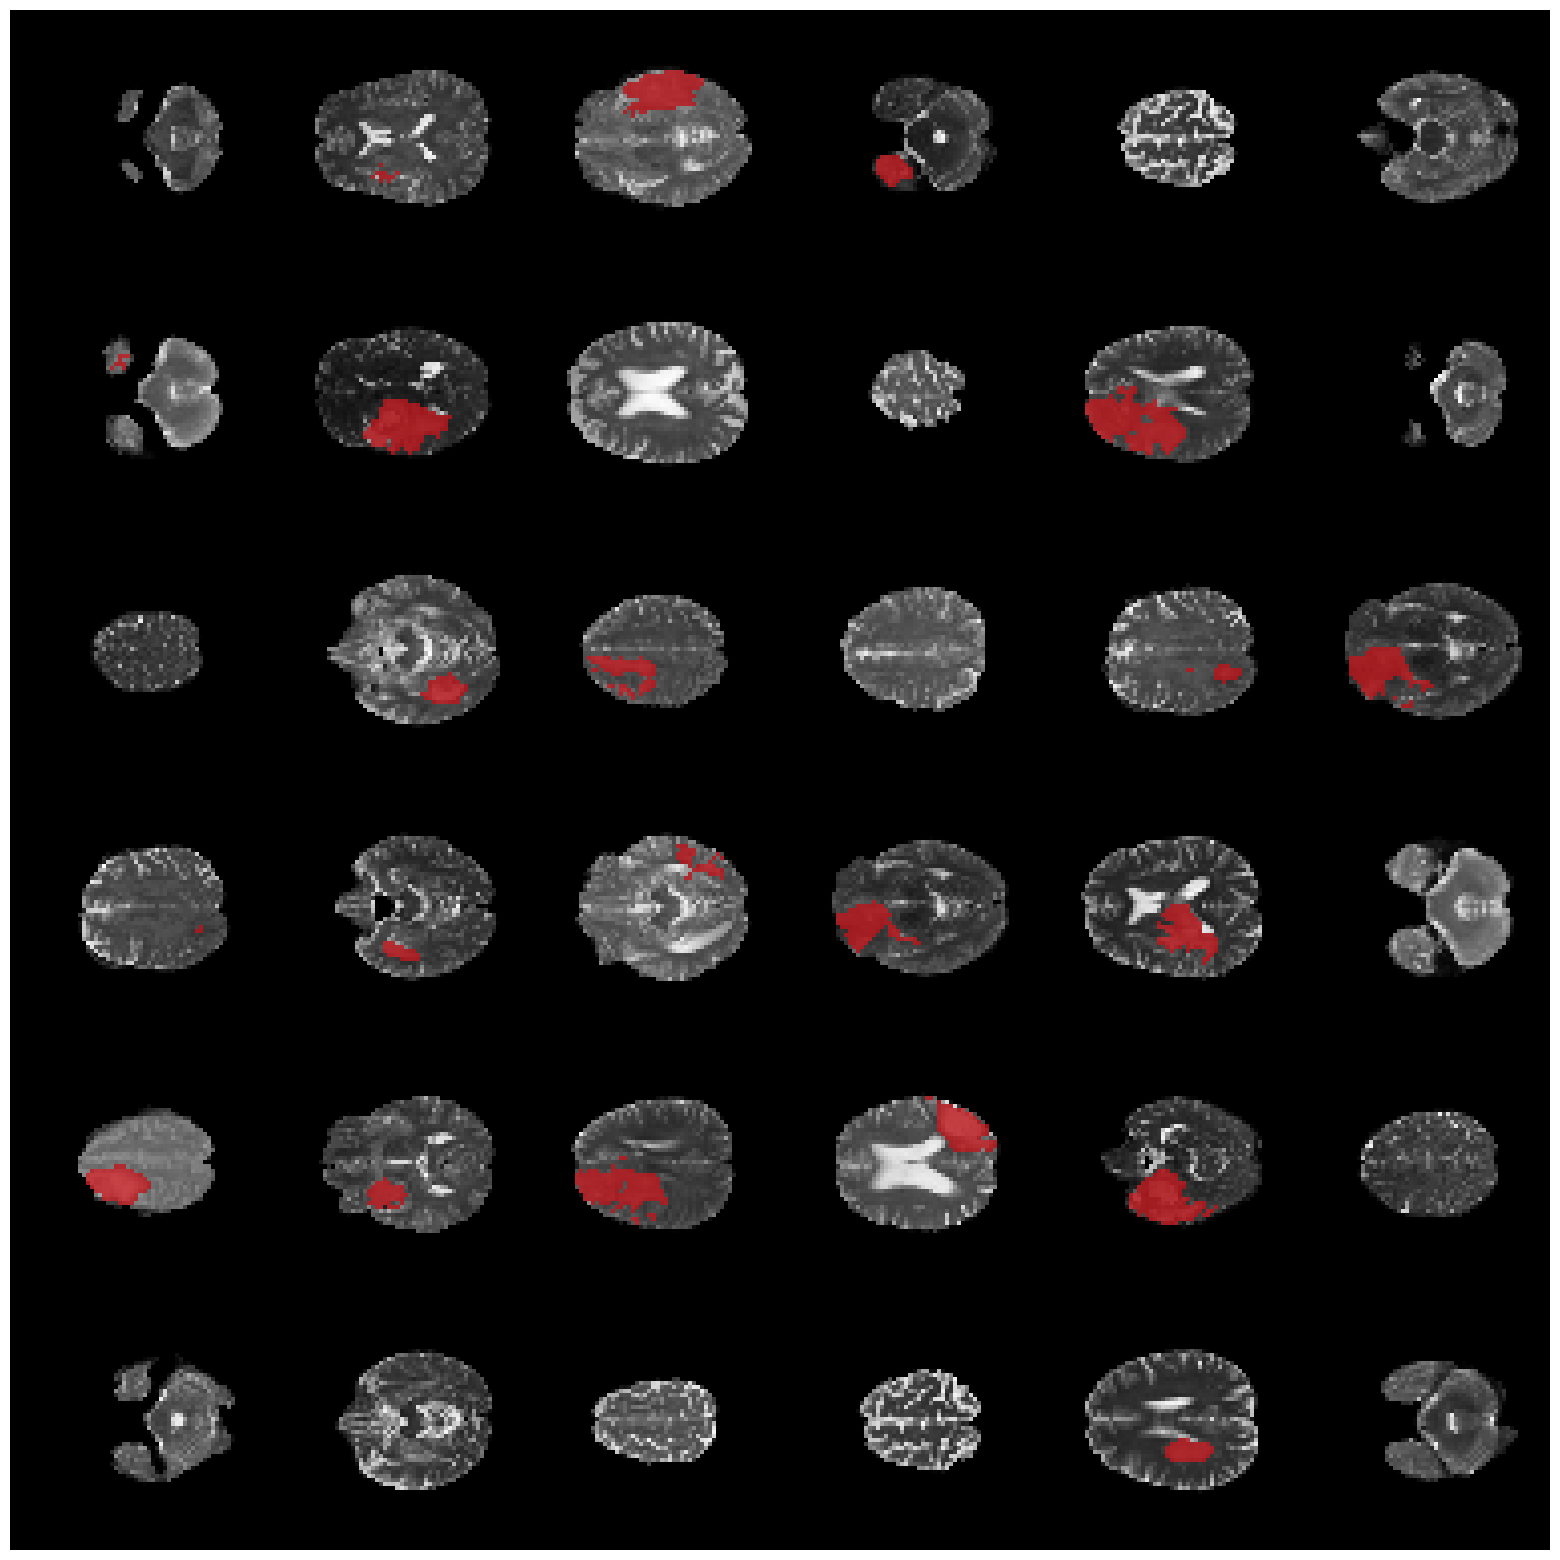

In [13]:
plot_predictions((all_test,all_test_masks), n=36, title="Test Samples")

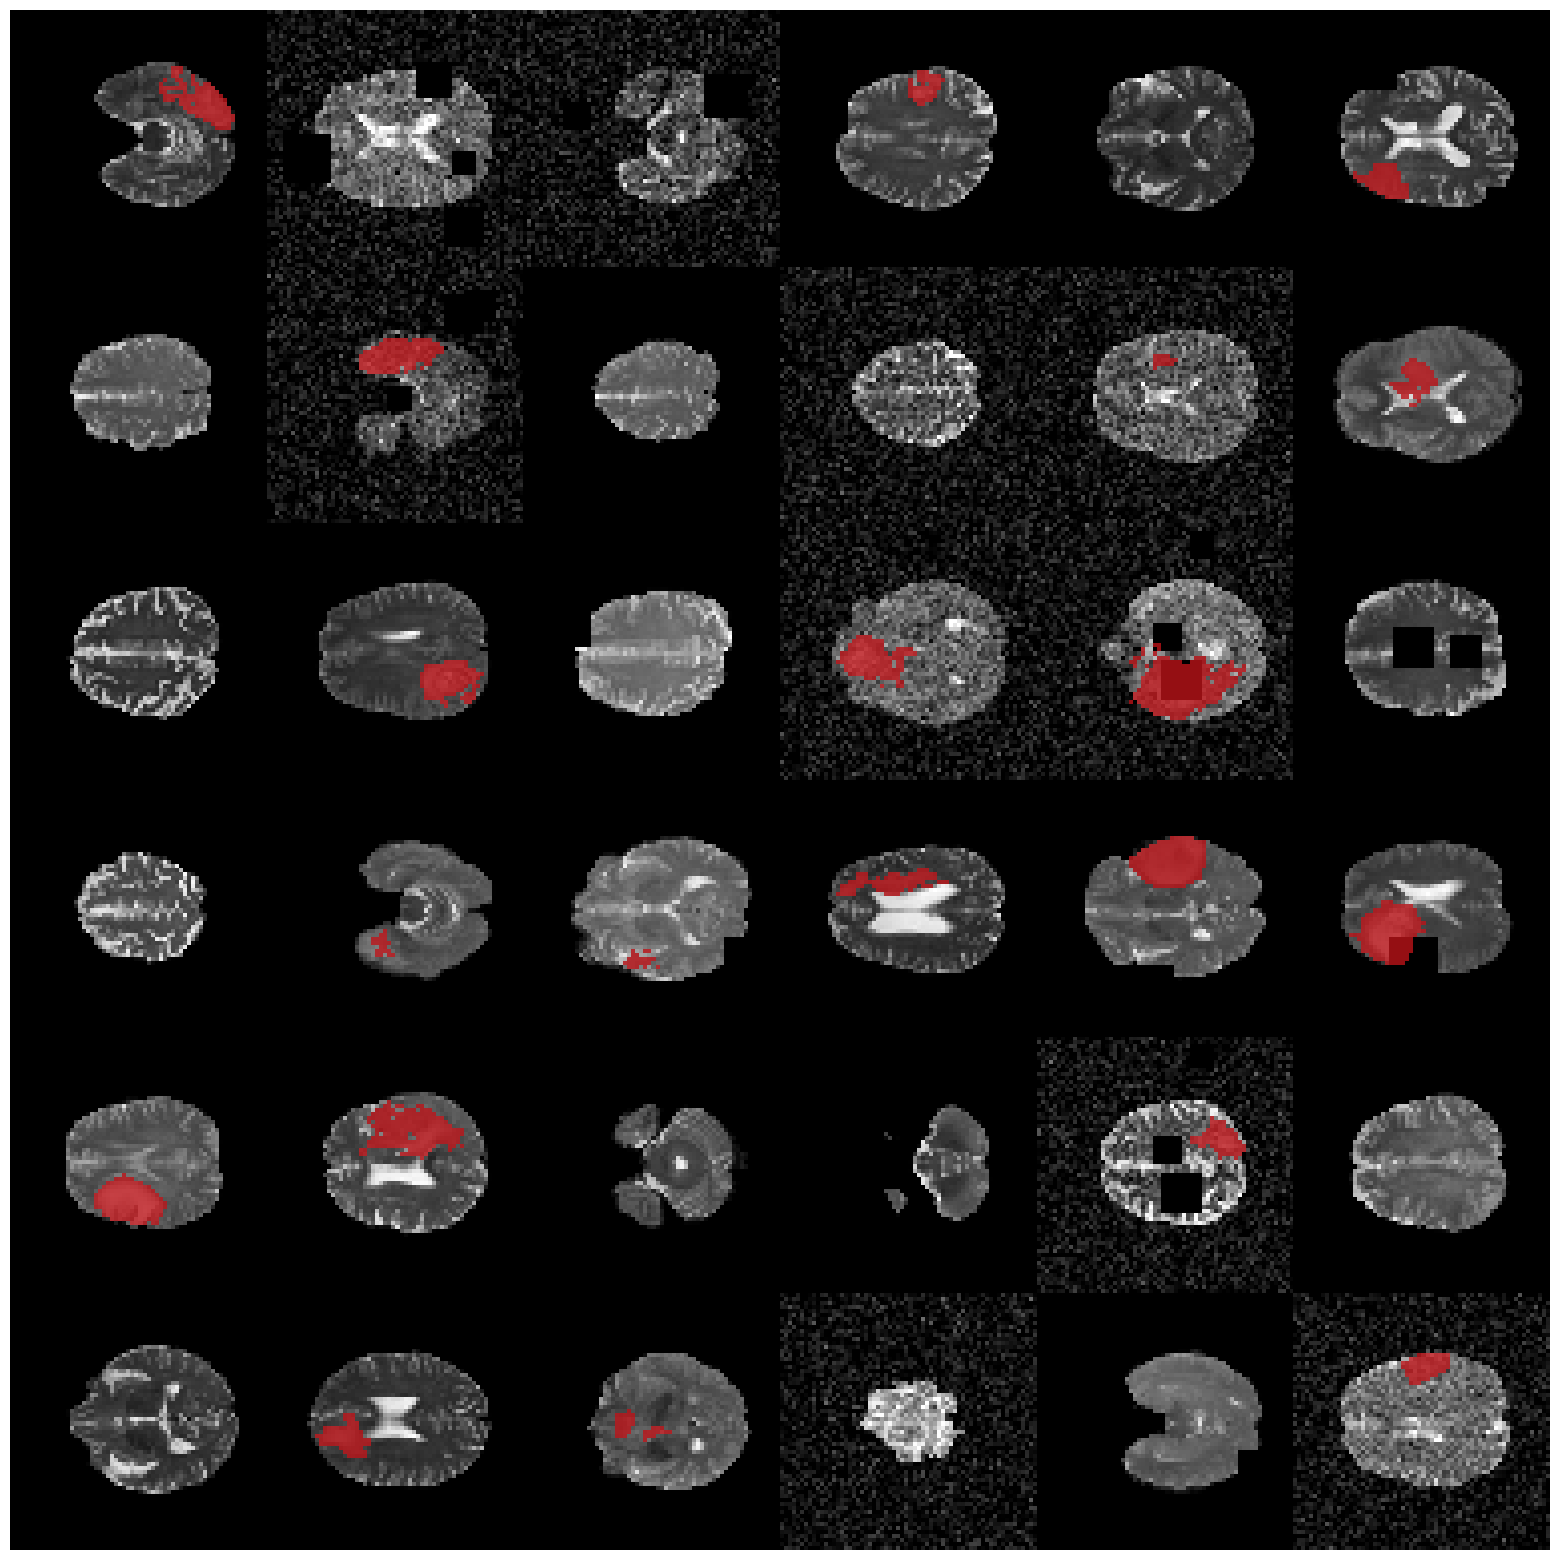

In [14]:
plot_predictions((all_train,all_train_masks), n=36, title="Test Samples")

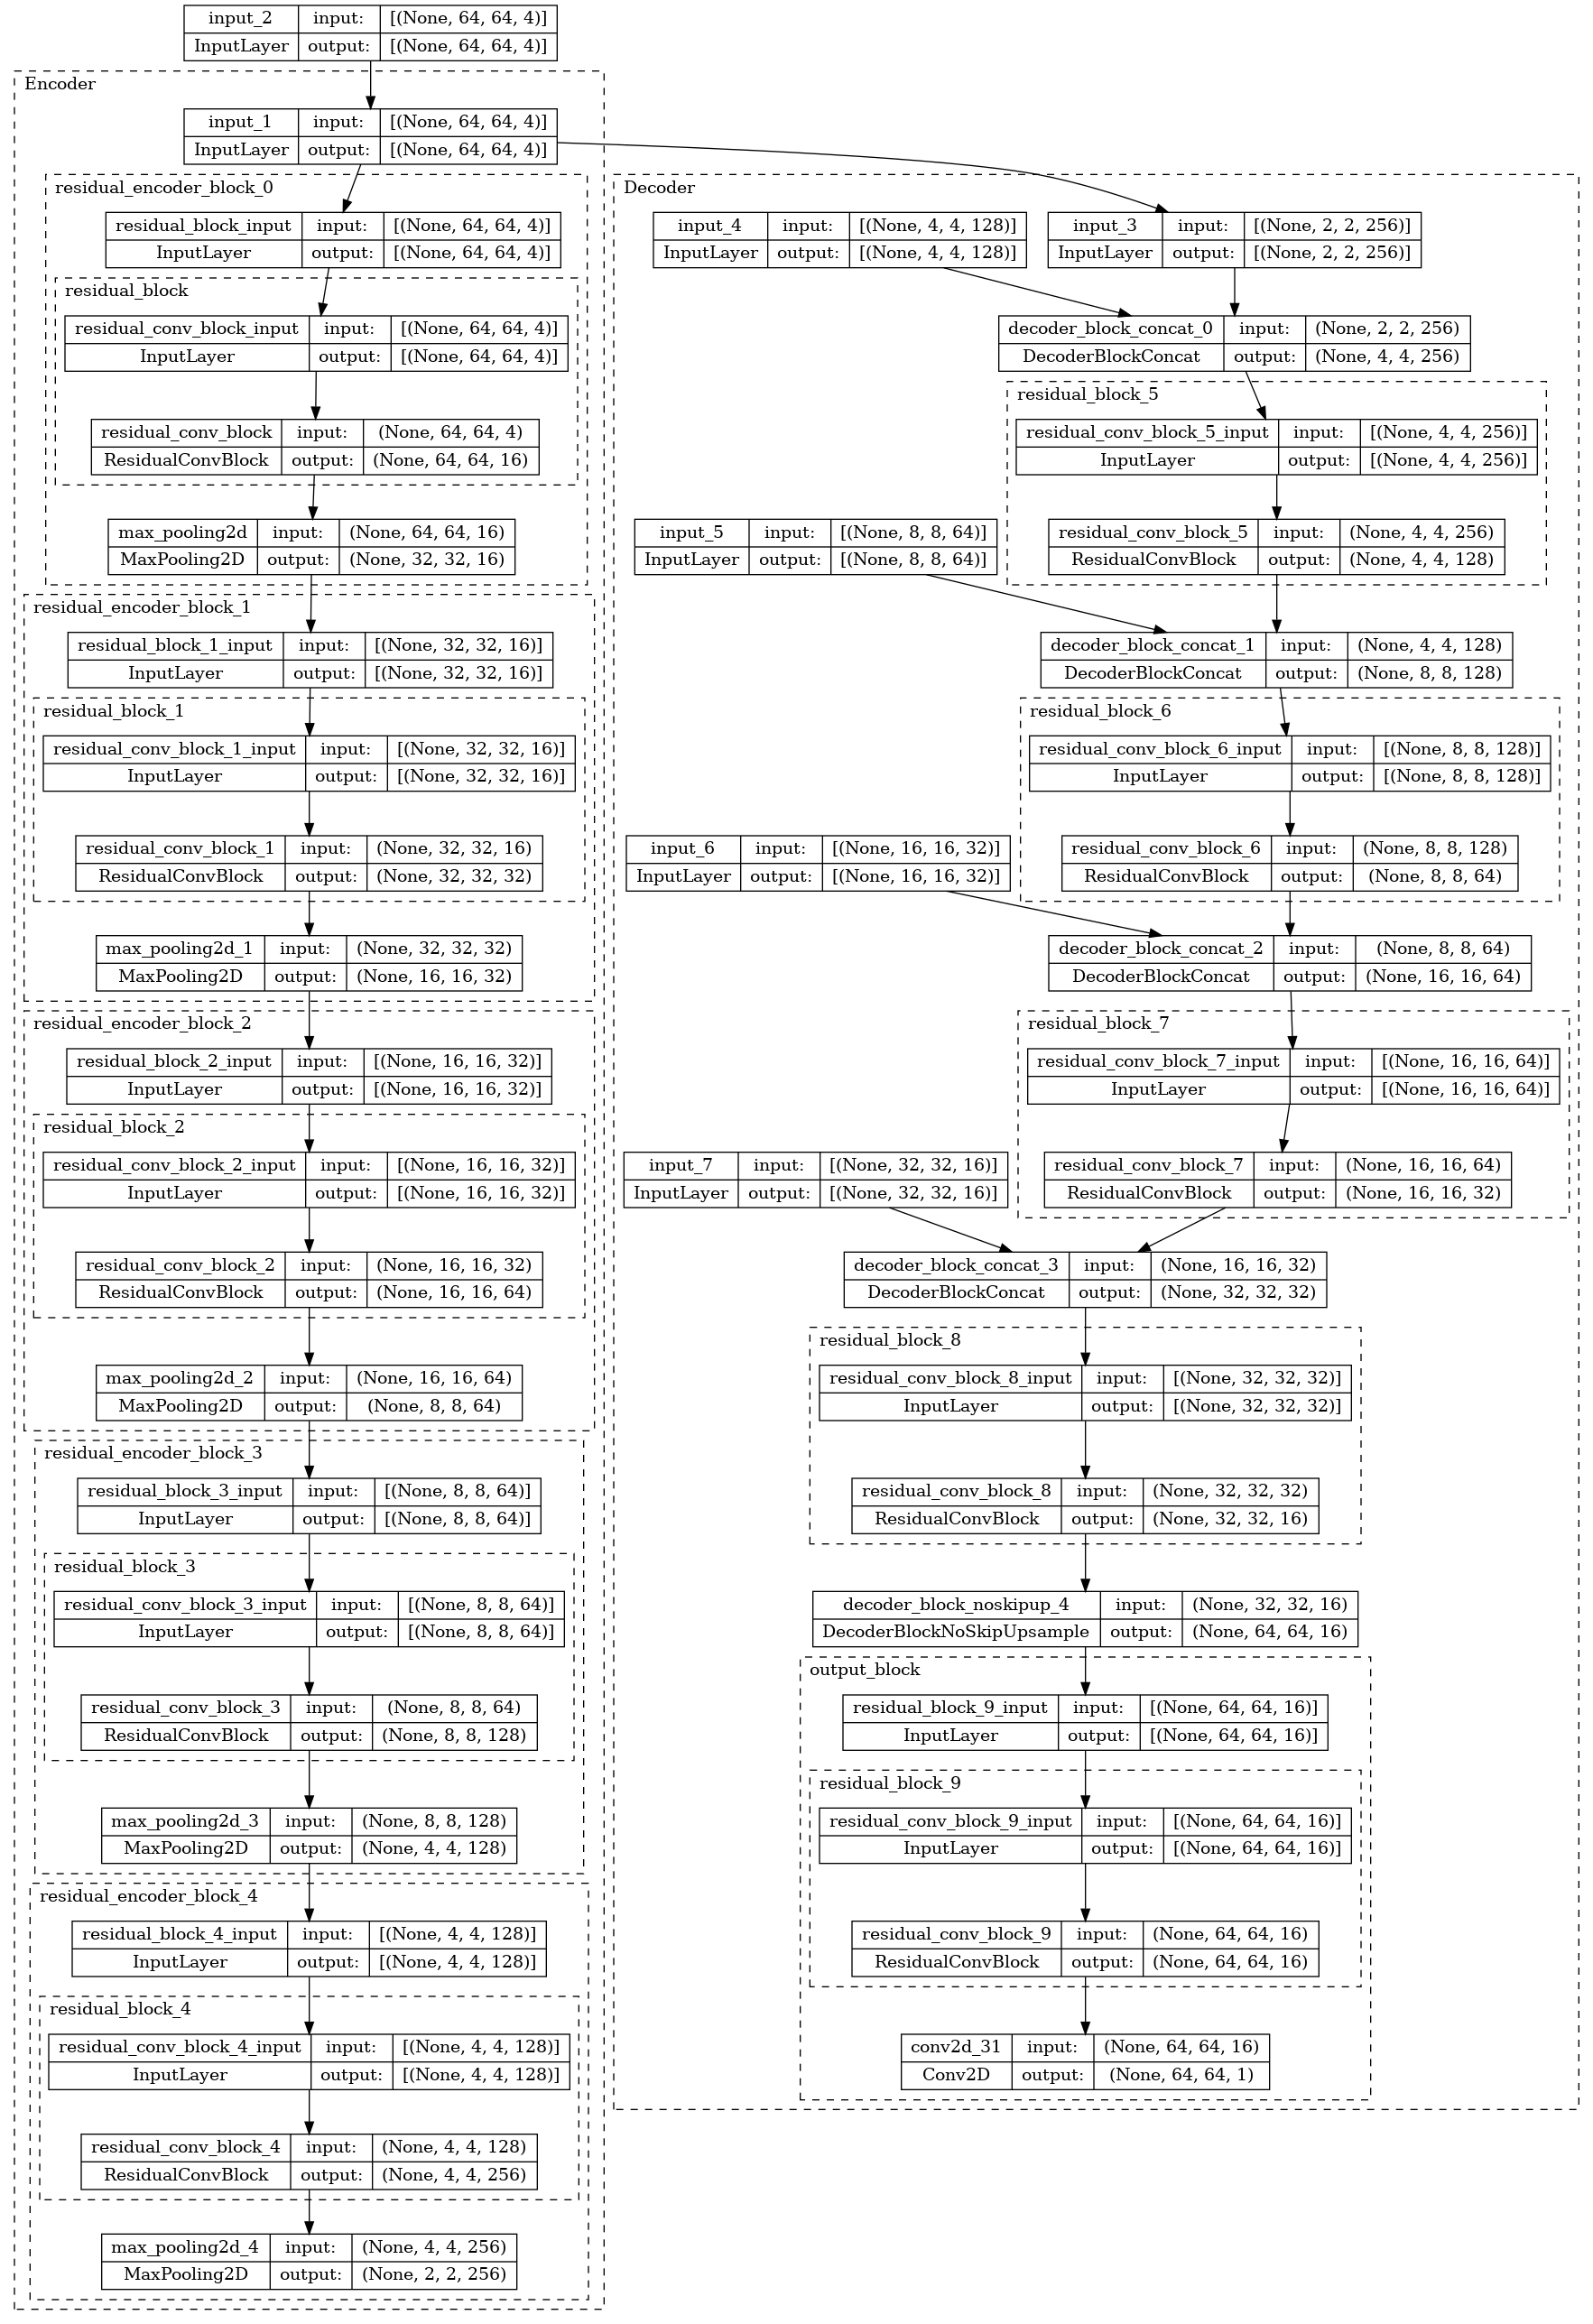

In [15]:
plot_model(unet, to_file=os.path.join("models/unet_final/figures", "unet.png"), show_shapes=True, show_layer_names=True,expand_nested=True)